### **Final Project** ###

Machine Learning 2023 Winter



Your name (Course ID): Sookyoung Park(f006dsq)

# Basic Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.metrics import silhouette_score, rand_score,adjusted_rand_score, confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve, auc

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder

from scipy.sparse import hstack, csr_matrix

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.cluster import KMeans
from sklearn.utils.multiclass import unique_labels

from sklearn.feature_extraction.text import CountVectorizer

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read Training/Test data

In [3]:
filename = '/content/drive/My Drive/Colab Notebooks/Training.csv'
train_data=pd.read_csv(filename)

filename = '/content/drive/My Drive/Colab Notebooks/Test.csv'
test_data=pd.read_csv(filename)

# Cutoff Labeling

In [ ]:
def cutoff(cutoff):
  
  label_encoder = LabelEncoder()

  #convert the target variable to 0/1
  train_data["classification"] = label_encoder.fit_transform(train_data["overall"].gt(cutoff))

# Text Vectorizer & Merge Sparse Matrix

In [ ]:
#convert verified boolean to sparse matrix

verified_csr_train=csr_matrix(train_data['verified'].values.astype(int))
verified_csr_train = verified_csr_train.transpose()

verified_csr_test=csr_matrix(test_data['verified'].values.astype(int))
verified_csr_test = verified_csr_test.transpose()

In [ ]:
type(train_data["reviewText"])

vectorizer = TfidfVectorizer()

# vectorizer to a sparse matrix
x_train_sprs_matrix_reviewText = vectorizer.fit_transform(train_data["reviewText"])

#print(vectorizer.vocabulary_)

tfidf1_test=TfidfVectorizer(vocabulary=vectorizer.vocabulary_)

x_test_sprs_matrix_reviewText = tfidf1_test.fit_transform(test_data["reviewText"])

In [ ]:
cvect = TfidfVectorizer()
no_NaN_summary_train = train_data["summary"].fillna(" ")
x_train_sprs_matrix_summary = cvect.fit_transform(no_NaN_summary_train)

no_NaN_summary_test = test_data["summary"].fillna(" ")

tfidf1_test_sum=TfidfVectorizer(vocabulary=cvect.vocabulary_)
x_test_sprs_matrix_summary = tfidf1_test_sum.fit_transform(no_NaN_summary_test)

In [ ]:
# merge CSR matrix
x_train_merged = hstack([x_train_sprs_matrix_reviewText, x_train_sprs_matrix_summary])
x_train_merged_all=hstack([x_train_merged,verified_csr_train])

x_test_merged=x_train_merged = hstack([x_test_sprs_matrix_reviewText, x_test_sprs_matrix_summary])
x_test_merged_all=hstack([x_test_merged,verified_csr_test])

## x_train/y_train

In [ ]:
x_train=x_train_merged_all
x_test=x_test_merged_all

# For Kaggle

In [ ]:
test_predicted=[0]*len(test_data)

# Cutoff 1

In [ ]:
cutoff(1)
y_train=train_data["classification"]

In [ ]:
# select k best features
k = 20802
selector = SelectKBest(f_classif, k=k)
selector.fit(x_train, y_train)

# transform train&test datasets to selected features
x_train_selected = selector.transform(x_train)
x_test_selected = selector.transform(x_test)

Logistic Regression

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


-----Confusion Matrix-----
[[1110  715]
 [ 337 6595]]




/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


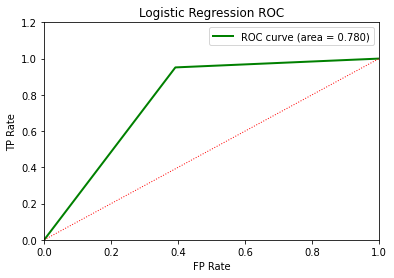


AUC:  0.7798020298951063
f1 score:  0.8023090387637516
Accuracy: 0.8798675345437935
Best parameters:  {'C': 45, 'max_iter': 70, 'solver': 'saga'}


In [ ]:
model = LogisticRegression()

X_train, X_val, y_train, y_val = train_test_split(x_train_selected, y_train, test_size=0.3, random_state=42)


#hyperparameters C:45, max_iter=70

param_grid = {'C': [45],
              'solver':['saga'], 
              'max_iter': [70],
              }

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring=make_scorer(accuracy_score))

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

prediction=best_model.predict(X_val)



cm = confusion_matrix(y_val, prediction)
print("-----Confusion Matrix-----")
print(cm)
print("\n")


# calculate roc
fpr, tpr, _ = roc_curve(y_val, prediction)
roc_auc = auc(fpr, tpr)

# plot ROC curve graph
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='dotted')

plt.title('Logistic Regression ROC')

plt.xlabel('FP Rate')
plt.ylabel('TP Rate')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.2])

plt.legend(loc="upper right")
plt.show()

print("\nAUC: ",roc_auc)

f1_macro = f1_score(y_val, prediction, average='macro')
print("f1 score: ",f1_macro) 

print("Accuracy:",accuracy_score(y_val,prediction))

print("Best parameters: ", grid_search.best_params_)

DecisionTree

-----Confusion Matrix-----
[[ 362 1463]
 [  40 6892]]




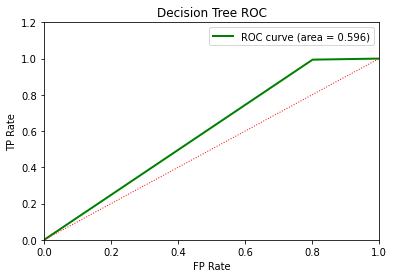


AUC:  0.5962929119667376
f1 score:  0.6133910998920843
Accuracy: 0.828365878725591
Best parameters:  {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 3}


In [ ]:
model = DecisionTreeClassifier()

# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(x_train_selected, y_train, test_size=0.3, random_state=42)

#hyperparameters
param_grid= {'criterion': ['gini'],
          'max_depth': [3],
          'min_samples_split': [3]
          }

grid_search = GridSearchCV(estimator=model,
                       param_grid=param_grid,
                       cv=5,
                       scoring='accuracy',
                       n_jobs=-1)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

prediction=best_model.predict(X_val)


cm = confusion_matrix(y_val, prediction)
print("-----Confusion Matrix-----")
print(cm)
print("\n")


# calculate roc
fpr, tpr, _ = roc_curve(y_val, prediction)
roc_auc = auc(fpr, tpr)

# plot ROC curve graph
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='dotted')

plt.title('Decision Tree ROC')

plt.xlabel('FP Rate')
plt.ylabel('TP Rate')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.2])

plt.legend(loc="upper right")
plt.show()

print("\nAUC: ",roc_auc)

f1_macro = f1_score(y_val, prediction, average='macro')
print("f1 score: ",f1_macro) 

print("Accuracy:",accuracy_score(y_val,prediction))

print("Best parameters: ", grid_search.best_params_)

RandomForest

-----Confusion Matrix-----
[[ 439 1386]
 [  23 6909]]




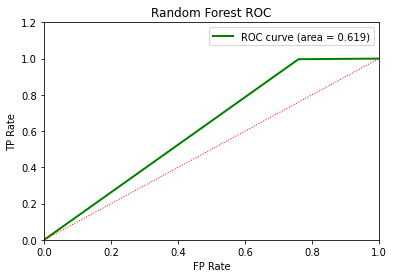


AUC:  0.6186149997233399
f1 score:  0.645688025283834
Accuracy: 0.8391001484526665
Best parameters:  {'max_depth': 1300, 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 90}


In [ ]:
rfc = RandomForestClassifier()

X_train, X_val, y_train, y_val = train_test_split(x_train_selected, y_train, test_size=0.3, random_state=42)

param_grid = {
    'n_estimators': [90],
    'max_depth': [1300],
    'min_samples_split': [20],
    'min_samples_leaf': [2]
}

# Grid Search
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_model=grid_search.best_estimator_

prediction = best_model.predict(X_val)


cm = confusion_matrix(y_val, prediction)
print("-----Confusion Matrix-----")
print(cm)
print("\n")


# calculate roc
fpr, tpr, _ = roc_curve(y_val, prediction)
roc_auc = auc(fpr, tpr)

# plot ROC curve graph
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='dotted')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.2])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('Random Forest ROC')
plt.legend(loc="upper right")
plt.show()

print("\nAUC: ",roc_auc)

f1_macro = f1_score(y_val, prediction, average='macro')
print("f1 score: ",f1_macro) 

print("Accuracy:",accuracy_score(y_val,prediction))

print("Best parameters: ", grid_search.best_params_)

In [ ]:
test_prediction=best_model.predict(x_test_selected)

#for kaggle

test_ids=test_data.index
test_submission=pd.DataFrame({'id':test_ids, 'predicted':test_prediction})
test_submission.to_csv("test_cutoff1_1.csv",index=False)

# Cutoff 2

In [ ]:
cutoff(2)
y_train=train_data["classification"]

In [ ]:
# select k best features 8000
k = 8000
selector = SelectKBest(f_classif, k=k)
selector.fit(x_train, y_train)

# transform train and test datasets with selected features
x_train_selected = selector.transform(x_train)
x_test_selected = selector.transform(x_test)

LogisticRegression

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


-----Confusion Matrix-----
[[2917  681]
 [ 587 4572]]




/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


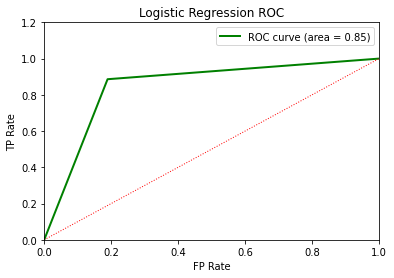


AUC:  0.8484732208380503
f1 score:  0.8498380927147617
Accuracy: 0.8552015530432797
Best parameters:  {'C': 45, 'max_iter': 63, 'solver': 'saga'}


In [ ]:
model = LogisticRegression()

# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(x_train_selected, y_train, test_size=0.3, random_state=42)


#hyperparameters
param_grid = {'C': [45],
              'solver':['saga'], 
              'max_iter': [63],
              }


# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring=make_scorer(accuracy_score))

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

prediction=best_model.predict(X_val)



cm = confusion_matrix(y_val, prediction)
print("-----Confusion Matrix-----")
print(cm)
print("\n")


# calculate roc
fpr, tpr, _ = roc_curve(y_val, prediction)
roc_auc = auc(fpr, tpr)

# plot ROC curve graph
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='dotted')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.2])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('Logistic Regression ROC')
plt.legend(loc="upper right")
plt.show()

print("\nAUC: ",roc_auc)

f1_macro = f1_score(y_val, prediction, average='macro')
print("f1 score: ",f1_macro) 

print("Accuracy:",accuracy_score(y_val,prediction))
print("Best parameters: ", grid_search.best_params_)

DecisionTree

-----Confusion Matrix-----
[[2256 1342]
 [1014 4145]]




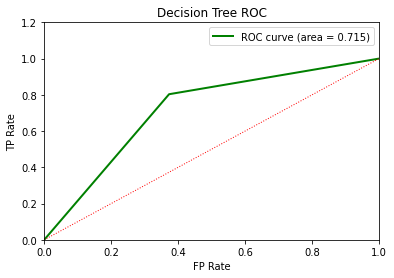


AUC:  0.7152326447000934
f1 score:  0.7178280187811468
Accuracy: 0.7309580906703209
Best parameters:  {'criterion': 'gini', 'max_depth': 32, 'min_samples_split': 5}


In [ ]:
model = DecisionTreeClassifier()

# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(x_train_selected, y_train, test_size=0.3, random_state=42)

#hyperparameters
param_grid= {'criterion': ['gini'],
          'max_depth': [32],
          'min_samples_split': [5]
          }

grid_search = GridSearchCV(estimator=model,
                       param_grid=param_grid,
                       cv=5,
                       scoring='accuracy',
                       n_jobs=-1)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

prediction=best_model.predict(X_val)


cm = confusion_matrix(y_val, prediction)
print("-----Confusion Matrix-----")
print(cm)
print("\n")


# calculate roc
fpr, tpr, _ = roc_curve(y_val, prediction)
roc_auc = auc(fpr, tpr)

# plot ROC curve graph
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='dotted')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.2])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('Decision Tree ROC')
plt.legend(loc="upper right")
plt.show()

print("\nAUC: ",roc_auc)

f1_macro = f1_score(y_val, prediction, average='macro')
print("f1 score: ",f1_macro) 

print("Accuracy:",accuracy_score(y_val,prediction))

print("Best parameters: ", grid_search.best_params_)

RandomForest

-----Confusion Matrix-----
[[2481 1117]
 [ 436 4723]]




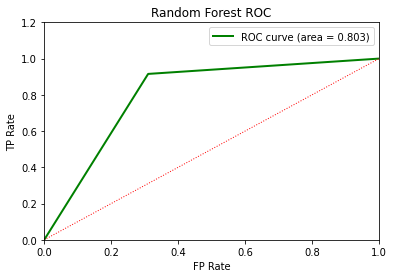


AUC:  0.8025186237190419
f1 score:  0.8102161802611373
Accuracy: 0.8226561607856572
Best parameters:  {'max_depth': 150, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}


In [ ]:
rfc = RandomForestClassifier()

X_train, X_val, y_train, y_val = train_test_split(x_train_selected, y_train, test_size=0.3, random_state=42)

param_grid = {
    'n_estimators': [500],
    'max_depth': [150],
    'min_samples_split': [10],
    'min_samples_leaf': [1]
}

# Grid Search
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_model=grid_search.best_estimator_

prediction = best_model.predict(X_val)


cm = confusion_matrix(y_val, prediction)
print("-----Confusion Matrix-----")
print(cm)
print("\n")


# calculate roc
fpr, tpr, _ = roc_curve(y_val, prediction)
roc_auc = auc(fpr, tpr)

# plot ROC curve graph
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='dotted')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.2])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('Random Forest ROC')
plt.legend(loc="upper right")
plt.show()

print("\nAUC: ",roc_auc)

f1_macro = f1_score(y_val, prediction, average='macro')
print("f1 score: ",f1_macro) 

print("Accuracy:",accuracy_score(y_val,prediction))

print("Best parameters: ", grid_search.best_params_)

In [ ]:
test_prediction=best_model.predict(x_test_selected)

#for kaggle

test_ids=test_data.index
test_submission=pd.DataFrame({'id':test_ids, 'predicted':test_prediction})
test_submission.to_csv("test_cutoff2_2.csv",index=False)

# Cutoff 3

In [ ]:
cutoff(3)
y_train=train_data["classification"]

In [ ]:
# select k best features 8500
k = 800
selector = SelectKBest(f_classif, k=k)
selector.fit(x_train, y_train)

# transform train and test datasets with selected features
x_train_selected = selector.transform(x_train)
x_test_selected = selector.transform(x_test)

LogisticRegression

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


-----Confusion Matrix-----
[[4859  530]
 [ 563 2805]]




/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


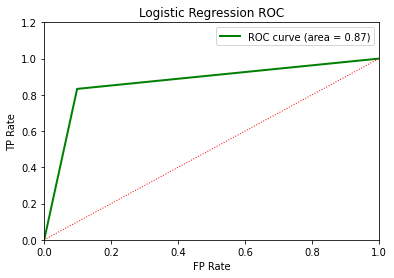


AUC:  0.8672449960749641
f1 score:  0.8679189767170272
Accuracy: 0.8751855658330479
Best parameters:  {'C': 64, 'max_iter': 90, 'solver': 'saga'}


In [ ]:
model = LogisticRegression()

# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(x_train_selected, y_train, test_size=0.3, random_state=42)


#hyperparameters
param_grid = {'C': [64],
              'solver':['saga'], 
              'max_iter': [90],
              }


# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring=make_scorer(accuracy_score))

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

prediction=best_model.predict(X_val)



cm = confusion_matrix(y_val, prediction)
print("-----Confusion Matrix-----")
print(cm)
print("\n")


# calculate roc
fpr, tpr, _ = roc_curve(y_val, prediction)
roc_auc = auc(fpr, tpr)

# plot ROC curve graph
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='dotted')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.2])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('Logistic Regression ROC')
plt.legend(loc="upper right")
plt.show()

print("\nAUC: ",roc_auc)

f1_macro = f1_score(y_val, prediction, average='macro')
print("f1 score: ",f1_macro) 

print("Accuracy:",accuracy_score(y_val,prediction))
print("Best parameters: ", grid_search.best_params_)

DecisionTree

-----Confusion Matrix-----
[[4702  687]
 [1255 2113]]




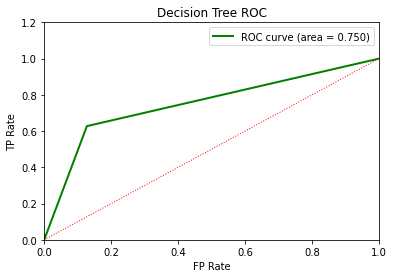


AUC:  0.7499466946612898
f1 score:  0.7569937570346532
Accuracy: 0.7782345552129725
Best parameters:  {'criterion': 'gini', 'max_depth': 23, 'min_samples_split': 2}


In [ ]:
model = DecisionTreeClassifier()

# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(x_train_selected, y_train, test_size=0.3, random_state=42)

#hyperparameters
param_grid= {'criterion': ['gini'],
          'max_depth': [23],
          'min_samples_split': [2]
          }

grid_search = GridSearchCV(estimator=model,
                       param_grid=param_grid,
                       cv=5,
                       scoring='accuracy',
                       n_jobs=-1)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

prediction=best_model.predict(X_val)


cm = confusion_matrix(y_val, prediction)
print("-----Confusion Matrix-----")
print(cm)
print("\n")


# calculate roc
fpr, tpr, _ = roc_curve(y_val, prediction)
roc_auc = auc(fpr, tpr)

# plot ROC curve graph
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='dotted')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.2])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('Decision Tree ROC')
plt.legend(loc="upper right")
plt.show()

print("\nAUC: ",roc_auc)

f1_macro = f1_score(y_val, prediction, average='macro')
print("f1 score: ",f1_macro) 

print("Accuracy:",accuracy_score(y_val,prediction))

print("Best parameters: ", grid_search.best_params_)

RandomForest

-----Confusion Matrix-----
[[5275  114]
 [1805 1563]]




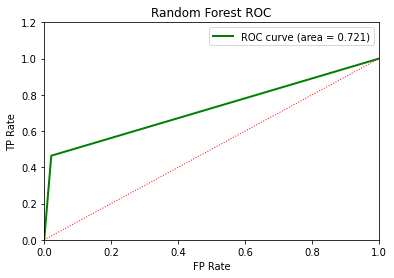


AUC:  0.721459715599076
f1 score:  0.7328608566688399
Accuracy: 0.780861025465342
Best parameters:  {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
rfc = RandomForestClassifier()

X_train, X_val, y_train, y_val = train_test_split(x_train_selected, y_train, test_size=0.3, random_state=42)

param_grid = {
    'n_estimators': [100],
    'max_depth': [15],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

# Grid Search
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_model=grid_search.best_estimator_

prediction = best_model.predict(X_val)


cm = confusion_matrix(y_val, prediction)
print("-----Confusion Matrix-----")
print(cm)
print("\n")


# calculate roc
fpr, tpr, _ = roc_curve(y_val, prediction)
roc_auc = auc(fpr, tpr)

# plot ROC curve graph
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='dotted')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.2])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('Random Forest ROC')
plt.legend(loc="upper right")
plt.show()

print("\nAUC: ",roc_auc)

f1_macro = f1_score(y_val, prediction, average='macro')
print("f1 score: ",f1_macro) 

print("Accuracy:",accuracy_score(y_val,prediction))

print("Best parameters: ", grid_search.best_params_)

In [ ]:
test_prediction=best_model.predict(x_test_selected)

#for kaggle

test_ids=test_data.index
test_submission=pd.DataFrame({'id':test_ids, 'predicted':test_prediction})
test_submission.to_csv("test_cutoff3_2.csv",index=False)

# Cutoff 4

In [ ]:
cutoff(4)
y_train=train_data["classification"]

In [ ]:
# select k best features
k = 100
selector = SelectKBest(f_classif, k=k)
selector.fit(x_train, y_train)

# transform train and test datasets with selected features
x_train_selected = selector.transform(x_train)
x_test_selected = selector.transform(x_test)

LogisticRegression

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


-----Confusion Matrix-----
[[6838  256]
 [ 546 1117]]




/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


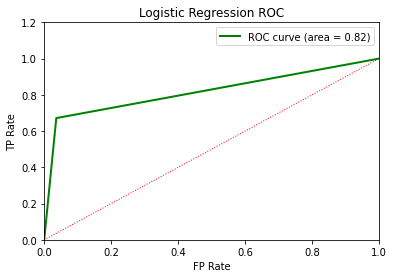


AUC:  0.817795428487923
f1 score:  0.8402211178252188
Accuracy: 0.9084161242434624
Best parameters:  {'C': 19, 'max_iter': 77, 'solver': 'saga'}


In [ ]:
model = LogisticRegression()

# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(x_train_selected, y_train, test_size=0.3, random_state=42)


#hyperparameters
param_grid = {'C': [19],
              'solver':['saga'], 
              'max_iter': [77],
              }


# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring=make_scorer(accuracy_score))

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

prediction=best_model.predict(X_val)



cm = confusion_matrix(y_val, prediction)
print("-----Confusion Matrix-----")
print(cm)
print("\n")


# calculate roc
fpr, tpr, _ = roc_curve(y_val, prediction)
roc_auc = auc(fpr, tpr)

# plot ROC curve graph
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='dotted')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.2])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('Logistic Regression ROC')
plt.legend(loc="upper right")
plt.show()

print("\nAUC: ",roc_auc)

f1_macro = f1_score(y_val, prediction, average='macro')
print("f1 score: ",f1_macro) 

print("Accuracy:",accuracy_score(y_val,prediction))
print("Best parameters: ", grid_search.best_params_)

DecisionTree

-----Confusion Matrix-----
[[6811  283]
 [ 834  829]]




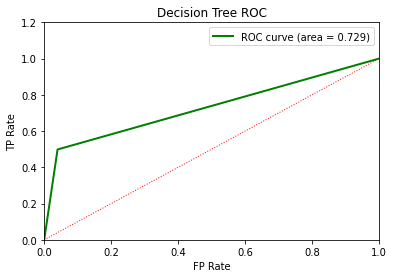


AUC:  0.7293019127561322
f1 score:  0.7608460730219331
Accuracy: 0.8724449012218797
Best parameters:  {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 3}


In [ ]:
model = DecisionTreeClassifier()

# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(x_train_selected, y_train, test_size=0.3, random_state=42)

#hyperparameters
param_grid= {'criterion': ['gini'],
          'max_depth': [10],
          'min_samples_split': [3]
          }

grid_search = GridSearchCV(estimator=model,
                       param_grid=param_grid,
                       cv=5,
                       scoring='accuracy',
                       n_jobs=-1)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

prediction=best_model.predict(X_val)


cm = confusion_matrix(y_val, prediction)
print("-----Confusion Matrix-----")
print(cm)
print("\n")


# calculate roc
fpr, tpr, _ = roc_curve(y_val, prediction)
roc_auc = auc(fpr, tpr)

# plot ROC curve graph
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='dotted')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.2])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('Decision Tree ROC')
plt.legend(loc="upper right")
plt.show()

print("\nAUC: ",roc_auc)

f1_macro = f1_score(y_val, prediction, average='macro')
print("f1 score: ",f1_macro) 

print("Accuracy:",accuracy_score(y_val,prediction))

print("Best parameters: ", grid_search.best_params_)

RandomForest

-----Confusion Matrix-----
[[6933  161]
 [ 844  819]]




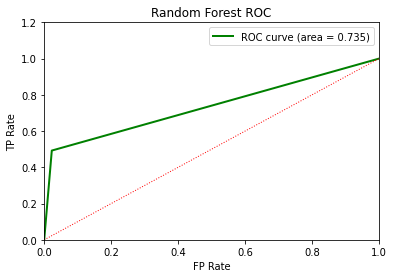


AUC:  0.734894114104879
f1 score:  0.7760845427315092
Accuracy: 0.8852346694073313
Best parameters:  {'max_depth': 80, 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 300}


In [ ]:
rfc = RandomForestClassifier()

X_train, X_val, y_train, y_val = train_test_split(x_train_selected, y_train, test_size=0.3, random_state=42)

param_grid = {
    'n_estimators': [300],
    'max_depth': [80],
    'min_samples_split': [7],
    'min_samples_leaf': [4]
}

# Grid Search
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_model=grid_search.best_estimator_

prediction = best_model.predict(X_val)


cm = confusion_matrix(y_val, prediction)
print("-----Confusion Matrix-----")
print(cm)
print("\n")


# calculate roc
fpr, tpr, _ = roc_curve(y_val, prediction)
roc_auc = auc(fpr, tpr)

# plot ROC curve graph
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='dotted')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.2])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('Random Forest ROC')
plt.legend(loc="upper right")
plt.show()

print("\nAUC: ",roc_auc)

f1_macro = f1_score(y_val, prediction, average='macro')
print("f1 score: ",f1_macro) 

print("Accuracy:",accuracy_score(y_val,prediction))

print("Best parameters: ", grid_search.best_params_)

In [ ]:
test_prediction=best_model.predict(x_test_selected)

#for kaggle

test_ids=test_data.index
test_submission=pd.DataFrame({'id':test_ids, 'predicted':test_prediction})
test_submission.to_csv("test_cutoff4_3.csv",index=False)

`Your report should describe why certain model parameters help or hurt the model performance.

You should report in your report the confusion
matrix, ROC, AUC, macro F1 score, and accuracy for the best combination of hyperparameters using 5-fold cross-validation.`

# Multi Classification

In [ ]:
y_train=train_data["overall"]

In [ ]:
# select k best features
k=5000
selector = SelectKBest(f_classif, k=k)
selector.fit(x_train, y_train)

# transform train and test datasets with selected features
x_train_selected = selector.transform(x_train)
x_test_selected = selector.transform(x_test)

RandomForest

-----Confusion Matrix-----
[[1277  369   64   54   61]
 [ 459  865  239  135   75]
 [ 164  411  800  322   94]
 [  87  164  226  941  287]
 [  85   82   56  293 1147]]




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


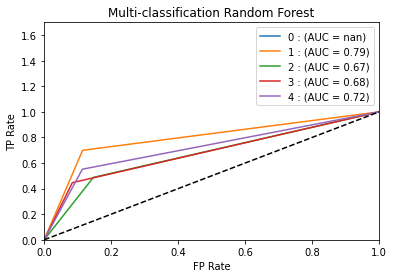

f1 score:  0.5732666310589538
Accuracy: 0.574397624757337
Best parameters:  {'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1300}


In [ ]:
rfc = RandomForestClassifier()

X_train, X_val, y_train, y_val = train_test_split(x_train_selected, y_train, test_size=0.3, random_state=42)

param_grid = {
    'n_estimators': [1300],
    'max_depth': [None],
    'min_samples_split': [4],
    'min_samples_leaf': [3],
}


# Grid Search
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_model=grid_search.best_estimator_

prediction = best_model.predict(X_val)


cm = confusion_matrix(y_val, prediction)
print("-----Confusion Matrix-----")
print(cm)
print("\n")

# One-hot encoding for multi-class prediction
n_classes = len(unique_labels(y_val, prediction))
one_hot_prediction = (prediction[:, None] == np.arange(n_classes)).astype(float)

# ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_val == i).astype(float), one_hot_prediction[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{i} : (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.7])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('Multi-classification Random Forest')
plt.legend(loc="upper right")
plt.show()

f1_macro = f1_score(y_val, prediction, average='macro')
print("f1 score: ",f1_macro) 
print("Accuracy:",accuracy_score(y_val,prediction))
print("Best parameters: ", grid_search.best_params_)

LogisticRegression

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means 

-----Confusion Matrix-----
[[1206  389  133   54   43]
 [ 362  920  309  133   49]
 [ 132  341  924  302   92]
 [  56  129  241  965  314]
 [  38   47  101  291 1186]]




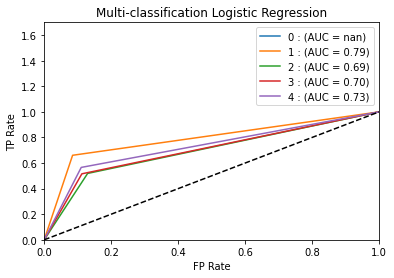

f1 score:  0.5948002245698316
Accuracy: 0.5939248601119105
Best parameters:  {'C': 45, 'max_iter': 70, 'solver': 'saga'}


In [ ]:
model=LogisticRegression()

X_train, X_val, y_train, y_val = train_test_split(x_train_selected, y_train, test_size=0.3, random_state=42)


#hyperparameters
param_grid = {'C': [45],
              'solver':['saga'], 
              'max_iter': [70],
              }


# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring=make_scorer(accuracy_score))

grid_search.fit(X_train, y_train)

best_model=grid_search.best_estimator_

prediction = best_model.predict(X_val)


cm = confusion_matrix(y_val, prediction)
print("-----Confusion Matrix-----")
print(cm)
print("\n")

# One-hot encoding for multi-class prediction
n_classes = len(unique_labels(y_val, prediction))
one_hot_prediction = (prediction[:, None] == np.arange(n_classes)).astype(float)

# ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_val == i).astype(float), one_hot_prediction[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{i} : (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.7])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('Multi-classification Logistic Regression')
plt.legend(loc="upper right")
plt.show()

f1_macro = f1_score(y_val, prediction, average='macro')
print("f1 score: ",f1_macro) 
print("Accuracy:",accuracy_score(y_val,prediction))
print("Best parameters: ", grid_search.best_params_)

In [ ]:
test_prediction=best_model.predict(x_test_selected)

#for kaggle

test_ids=test_data.index
test_submission=pd.DataFrame({'id':test_ids, 'predicted':test_prediction})
test_submission.to_csv("test_multi_1.csv",index=False)

DecisionTree Classifier

-----Confusion Matrix-----
[[1182  327  146   98   72]
 [ 590  689  248  166   80]
 [ 370  412  637  271  101]
 [ 272  268  220  688  257]
 [ 314  140   99  233  877]]




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


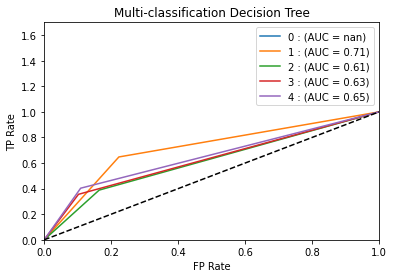

f1 score:  0.4634063758169294
Accuracy: 0.4651136233870047
Best parameters:  {'criterion': 'gini', 'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
model = DecisionTreeClassifier()

X_train, X_val, y_train, y_val = train_test_split(x_train_selected, y_train, test_size=0.3, random_state=42)

param_grid = {
    'criterion': ['gini'],
    'max_depth': [25],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

# Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_model=grid_search.best_estimator_

prediction = best_model.predict(X_val)


cm = confusion_matrix(y_val, prediction)
print("-----Confusion Matrix-----")
print(cm)
print("\n")

# One-hot encoding for multi-class prediction
n_classes = len(unique_labels(y_val, prediction))
one_hot_prediction = (prediction[:, None] == np.arange(n_classes)).astype(float)

# ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_val == i).astype(float), one_hot_prediction[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{i} : (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.7])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('Multi-classification Decision Tree')
plt.legend(loc="upper right")
plt.show()

f1_macro = f1_score(y_val, prediction, average='macro')
print("f1 score: ",f1_macro) 
print("Accuracy:",accuracy_score(y_val,prediction))
print("Best parameters: ", grid_search.best_params_)

report the confusion matrix, ROC, AUC, macro F1 score, and accuracy

# Clustering

In [ ]:
#cluster the product reviews in the test dataset
#need to create word features from the data and use that for k-means clustering
#labels will be product categories

#use the Silhouette score and Rand index to analyze the quality of clustering
#will share a baseline silhouette score for clustering, and your model must achieve at least the baseline score for full credit.

In [ ]:
categories = len(test_data['category'].unique()) 
#train_data['category'].unique()

In [ ]:
type(test_data["reviewText"])

vectorizer = CountVectorizer(stop_words='english', 
                             lowercase=True,
                             )

x_test_vectorized = vectorizer.fit_transform(test_data['reviewText'])

In [ ]:
# Perform k-means clustering with k=5 40
kmeans = KMeans(n_clusters=5, random_state=40)
kmeans.fit(x_test_vectorized)
cluster_labels=kmeans.labels_

# Evaluate clustering quality using Silhouette score and Rand index
silhouette = silhouette_score(x_test_vectorized, cluster_labels)
rand_index = rand_score(test_data["category"], cluster_labels)

print("Silhouette score: ", silhouette)
print("Rand index: ", rand_index)


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score:  0.7233433128592512
Rand index:  0.17034521251636167
